In [1]:
from yako_util import util as q
from yako_util import era5 as era5
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn.metrics as metrics
from metpy.calc import mixing_ratio_from_specific_humidity, density
from metpy.units import units
from metpy.constants import g

/home/mykhailo/micromamba/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
files = q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase/2014')

tc_gmi_files = sorted(list(filter(lambda x: 'gmi_tc' in x, files)))
tc_sim_scatt_files = sorted(list(filter(lambda x: 'Tc_hydro_13ch' in x, files)))
tc_sim_clear_files = sorted(list(filter(lambda x: 'Tc_clear_13ch' in x, files)))

specific_humidity_files = sorted(list(filter(lambda x: 'era5_specific_humidity' in x, files)))
temperature_files = sorted(list(filter(lambda x: 'era5_temperature' in x, files)))
surface_pressure_files = sorted(list(filter(lambda x: 'surface_pressure' in x, files)))
tm_temperature_files = sorted(list(filter(lambda x: 'era5_2m_temperature' in x, files)))
cloud_liquid_water_files = sorted(list(filter(lambda x: 'era5_cloud_liqud_water' in x, files)))
cloud_ice_water_files = sorted(list(filter(lambda x: 'era5_cloud_ice_water' in x, files)))
precip_liquid_water_files = sorted(list(filter(lambda x: 'era5_precip_liquid_water' in x, files)))
precip_ice_water_files = sorted(list(filter(lambda x: 'era5_precip_ice_water' in x, files)))

lat_files = sorted(list(filter(lambda x: 'gmi_lat' in x, files)))
lon_files = sorted(list(filter(lambda x: 'gmi_lon' in x, files)))

autosnow_files = sorted(list(filter(lambda x: 'autosnow' in x, files)))

In [3]:
tc_gmi = np.concatenate(list(map(np.load, tc_gmi_files)), axis=0)
tc_sim_scatt = np.concatenate(list(map(np.load, tc_sim_scatt_files)), axis=0)
tc_sim_clear = np.concatenate(list(map(np.load, tc_sim_clear_files)), axis=0)

lat = np.concatenate(list(map(np.load, lat_files)), axis=0)
lon = np.concatenate(list(map(np.load, lon_files)), axis=0)

pressure = np.tile(era5.get_pressure_levels()[::-1], (tc_gmi.shape[0], 1))
nprofiles = pressure.shape[0]
nlevels = pressure.shape[1]

surface_pressure = np.concatenate(list(map(np.load, surface_pressure_files)), axis=0).reshape(nprofiles)
tm_temperature = np.concatenate(list(map(np.load, tm_temperature_files)), axis=0).reshape(nprofiles)
autosnow = np.concatenate(list(map(np.load, autosnow_files)), axis=0).reshape(nprofiles)

specific_humidity = np.concatenate(list(map(np.load, specific_humidity_files)), axis=0).reshape(nprofiles, nlevels)
temperature = np.concatenate(list(map(np.load, temperature_files)), axis=0).reshape(nprofiles, nlevels)
cloud_liquid_water = np.concatenate(list(map(np.load, cloud_liquid_water_files)), axis=0).reshape(nprofiles, nlevels)
cloud_ice_water = np.concatenate(list(map(np.load, cloud_ice_water_files)), axis=0).reshape(nprofiles, nlevels)
precip_liquid_water = np.concatenate(list(map(np.load, precip_liquid_water_files)), axis=0).reshape(nprofiles, nlevels)
precip_ice_water = np.concatenate(list(map(np.load, precip_ice_water_files)), axis=0).reshape(nprofiles, nlevels)

In [4]:
mixing_ratio = mixing_ratio_from_specific_humidity(specific_humidity * units('kg/kg')).to('g/kg')
moist_air_density = density(pressure * units.hPa, temperature * units.K, mixing_ratio).to('kg/m3')

qr_avg = (precip_liquid_water[:,:-1] + precip_liquid_water[:,1:]) / 2
qi_avg = (precip_ice_water[:,:-1] + precip_ice_water[:,1:]) / 2
qc_avg = (cloud_liquid_water[:,:-1] + cloud_liquid_water[:,1:]) / 2
qci_avg = (cloud_ice_water[:,:-1] + cloud_ice_water[:,1:]) / 2

dp = -np.diff((pressure*units.hPa).to(units.Pa), axis=1)
tcwv = np.sum(((qr_avg + qi_avg + qc_avg + qci_avg) * dp) / g, axis=1).to('kg/m2').m

0 - water only \
1 - land only \
2 - snow land only \
3 - ice only \
4 - frozen sea (ice and water) \
5 - beach (land and water) \
6 - frozen beach (snow/land and water/ice) \
7 - glacier (snow/land and ice)

In [5]:
valid_mask = (
    np.all(tc_gmi >= 50, axis=1) &
    np.all(tc_gmi <= 500, axis=1) &
    np.all(tc_sim_scatt >= 50, axis=1) &
    np.all(tc_sim_scatt <= 500, axis=1) &
    np.all(tc_sim_clear >= 50, axis=1) &
    np.all(tc_sim_clear <= 500, axis=1)
)

sea_mask = autosnow == 0
land_mask = autosnow == 1
snow_mask = autosnow == 2
ice_mask = autosnow == 3
frozen_sea_mask = autosnow == 4
beach_mask = (autosnow == 5) | (autosnow == 6)
glacier_mask = autosnow == 7

In [6]:
channels = q.gmi_channels()

Text(0.5, 1.0, 'RTTOV-SCATT Tb for 10.6 V')

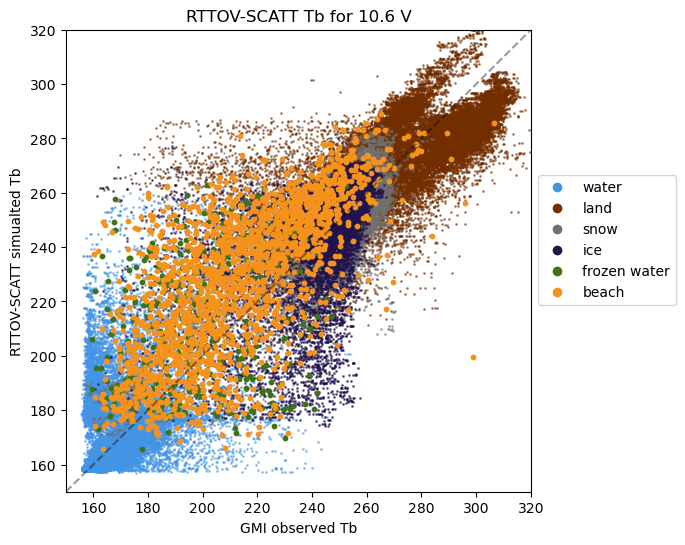

In [10]:
plt.figure(figsize=(6, 6))
plt.plot([150, 320], [150, 320], linestyle='--', c='black', alpha=0.4)
plt.scatter(tc_gmi[valid_mask&sea_mask,0], tc_sim_scatt[valid_mask&sea_mask,0], s=1, alpha=0.5, c='#4394E5')
plt.scatter(tc_gmi[valid_mask&land_mask,0], tc_sim_scatt[valid_mask&land_mask,0], s=1, alpha=0.5, c='#732E00')
plt.scatter(tc_gmi[valid_mask&snow_mask,0], tc_sim_scatt[valid_mask&snow_mask,0], s=1, alpha=0.5, c='#707070')
plt.scatter(tc_gmi[valid_mask&ice_mask,0], tc_sim_scatt[valid_mask&ice_mask,0], s=1, alpha=0.6, c='#21134D')
plt.scatter(tc_gmi[valid_mask&frozen_sea_mask,0], tc_sim_scatt[valid_mask&frozen_sea_mask,0], s=10, alpha=1, c='#3D7317')
plt.scatter(tc_gmi[valid_mask&beach_mask,0], tc_sim_scatt[valid_mask&beach_mask,0], s=10, alpha=1, c='#F5921B')

legend_handles = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4394E5', markersize=8, label='water'),
matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#732E00', markersize=8, label='land'),
matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#707070', markersize=8, label='snow'),
matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#21134D', markersize=8, label='ice'),
matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#3D7317', markersize=8, label='frozen water'),
matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#F5921B', markersize=8, label='beach'),
]

plt.legend(handles=legend_handles, bbox_to_anchor=(1, 0.7))
plt.xlim(150, 320)
plt.ylim(150, 320)

plt.xlabel('GMI observed Tb')
plt.ylabel('RTTOV-SCATT simualted Tb')

plt.title(f'RTTOV-SCATT Tb for {channels[0]}')

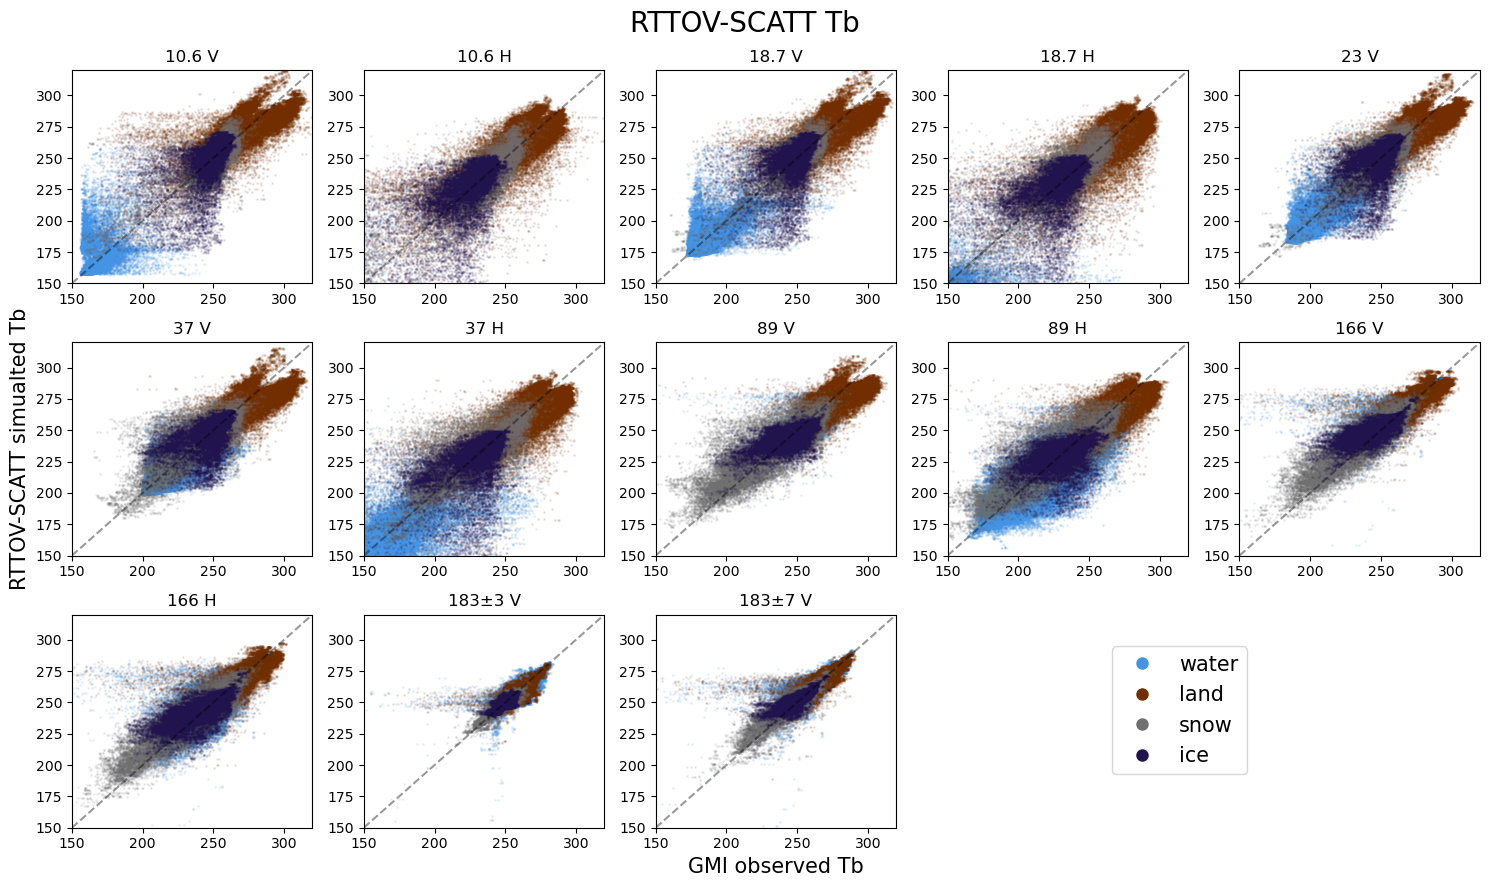

In [11]:
plt.figure(figsize=(15, 9))

for chan in range(13):
    plt.subplot(3, 5, chan+1)

    plt.plot([150, 320], [150, 320], linestyle='--', c='black', alpha=0.4)
    plt.scatter(tc_gmi[valid_mask&sea_mask,chan], tc_sim_scatt[valid_mask&sea_mask,chan], s=1, alpha=0.1, c='#4394E5', label='water')
    plt.scatter(tc_gmi[valid_mask&land_mask,chan], tc_sim_scatt[valid_mask&land_mask,chan], s=1, alpha=0.1, c='#732E00', label='land')
    plt.scatter(tc_gmi[valid_mask&snow_mask,chan], tc_sim_scatt[valid_mask&snow_mask,chan], s=1, alpha=0.1, c='#707070', label='snow')
    plt.scatter(tc_gmi[valid_mask&ice_mask,chan], tc_sim_scatt[valid_mask&ice_mask,chan], s=1, alpha=0.1, c='#21134D', label='ice')
    plt.xlim(150, 320)
    plt.ylim(150, 320)
    if chan == 12:
        plt.xlabel('GMI observed Tb', fontsize=15)
    if chan == 5:
        plt.ylabel('RTTOV-SCATT simualted Tb', fontsize=15)

    plt.title(channels[chan])

plt.suptitle('RTTOV-SCATT Tb', fontsize=20)
plt.tight_layout()

legend_handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4394E5', markersize=10, label='water'),
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#732E00', markersize=10, label='land'),
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#707070', markersize=10, label='snow'),
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#21134D', markersize=10, label='ice'),
]
plt.legend(handles=legend_handles, bbox_to_anchor=(2.5, 0.9), fontsize=15)

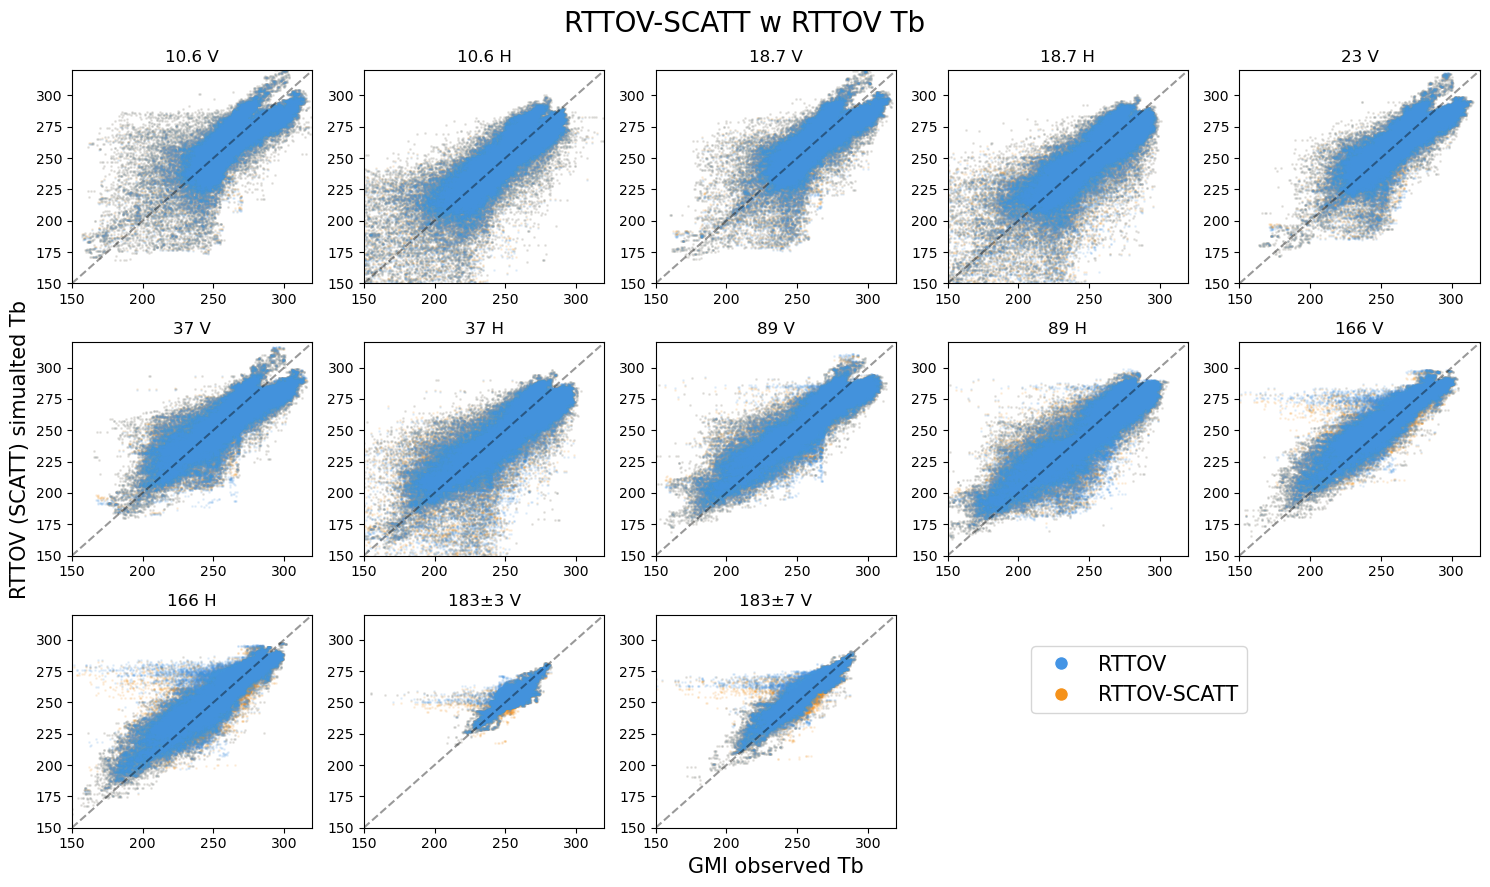

In [12]:
use_mask = land_mask | snow_mask | ice_mask

plt.figure(figsize=(15, 9))

for chan in range(13):
    plt.subplot(3, 5, chan+1)

    plt.plot([150, 320], [150, 320], linestyle='--', c='black', alpha=0.4)
    plt.scatter(tc_gmi[valid_mask&use_mask,chan], tc_sim_scatt[valid_mask&use_mask,chan], s=1, alpha=0.1, c='#F5921B', label='RTTOV-SCATT')
    plt.scatter(tc_gmi[valid_mask&use_mask,chan], tc_sim_clear[valid_mask&use_mask,chan], s=1, alpha=0.1, c='#4394E5', label='RTTOV')
    plt.xlim(150, 320)
    plt.ylim(150, 320)
    if chan == 12:
        plt.xlabel('GMI observed Tb', fontsize=15)
    if chan == 5:
        plt.ylabel('RTTOV (SCATT) simualted Tb', fontsize=15)

    plt.title(channels[chan])

plt.suptitle('RTTOV-SCATT w RTTOV Tb', fontsize=20)
plt.tight_layout()

legend_handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4394E5', markersize=10, label='RTTOV'),
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#F5921B', markersize=10, label='RTTOV-SCATT'),
]
plt.legend(handles=legend_handles, bbox_to_anchor=(2.5, 0.9), fontsize=15)

/home/mykhailo/micromamba/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mykhailo/micromamba/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


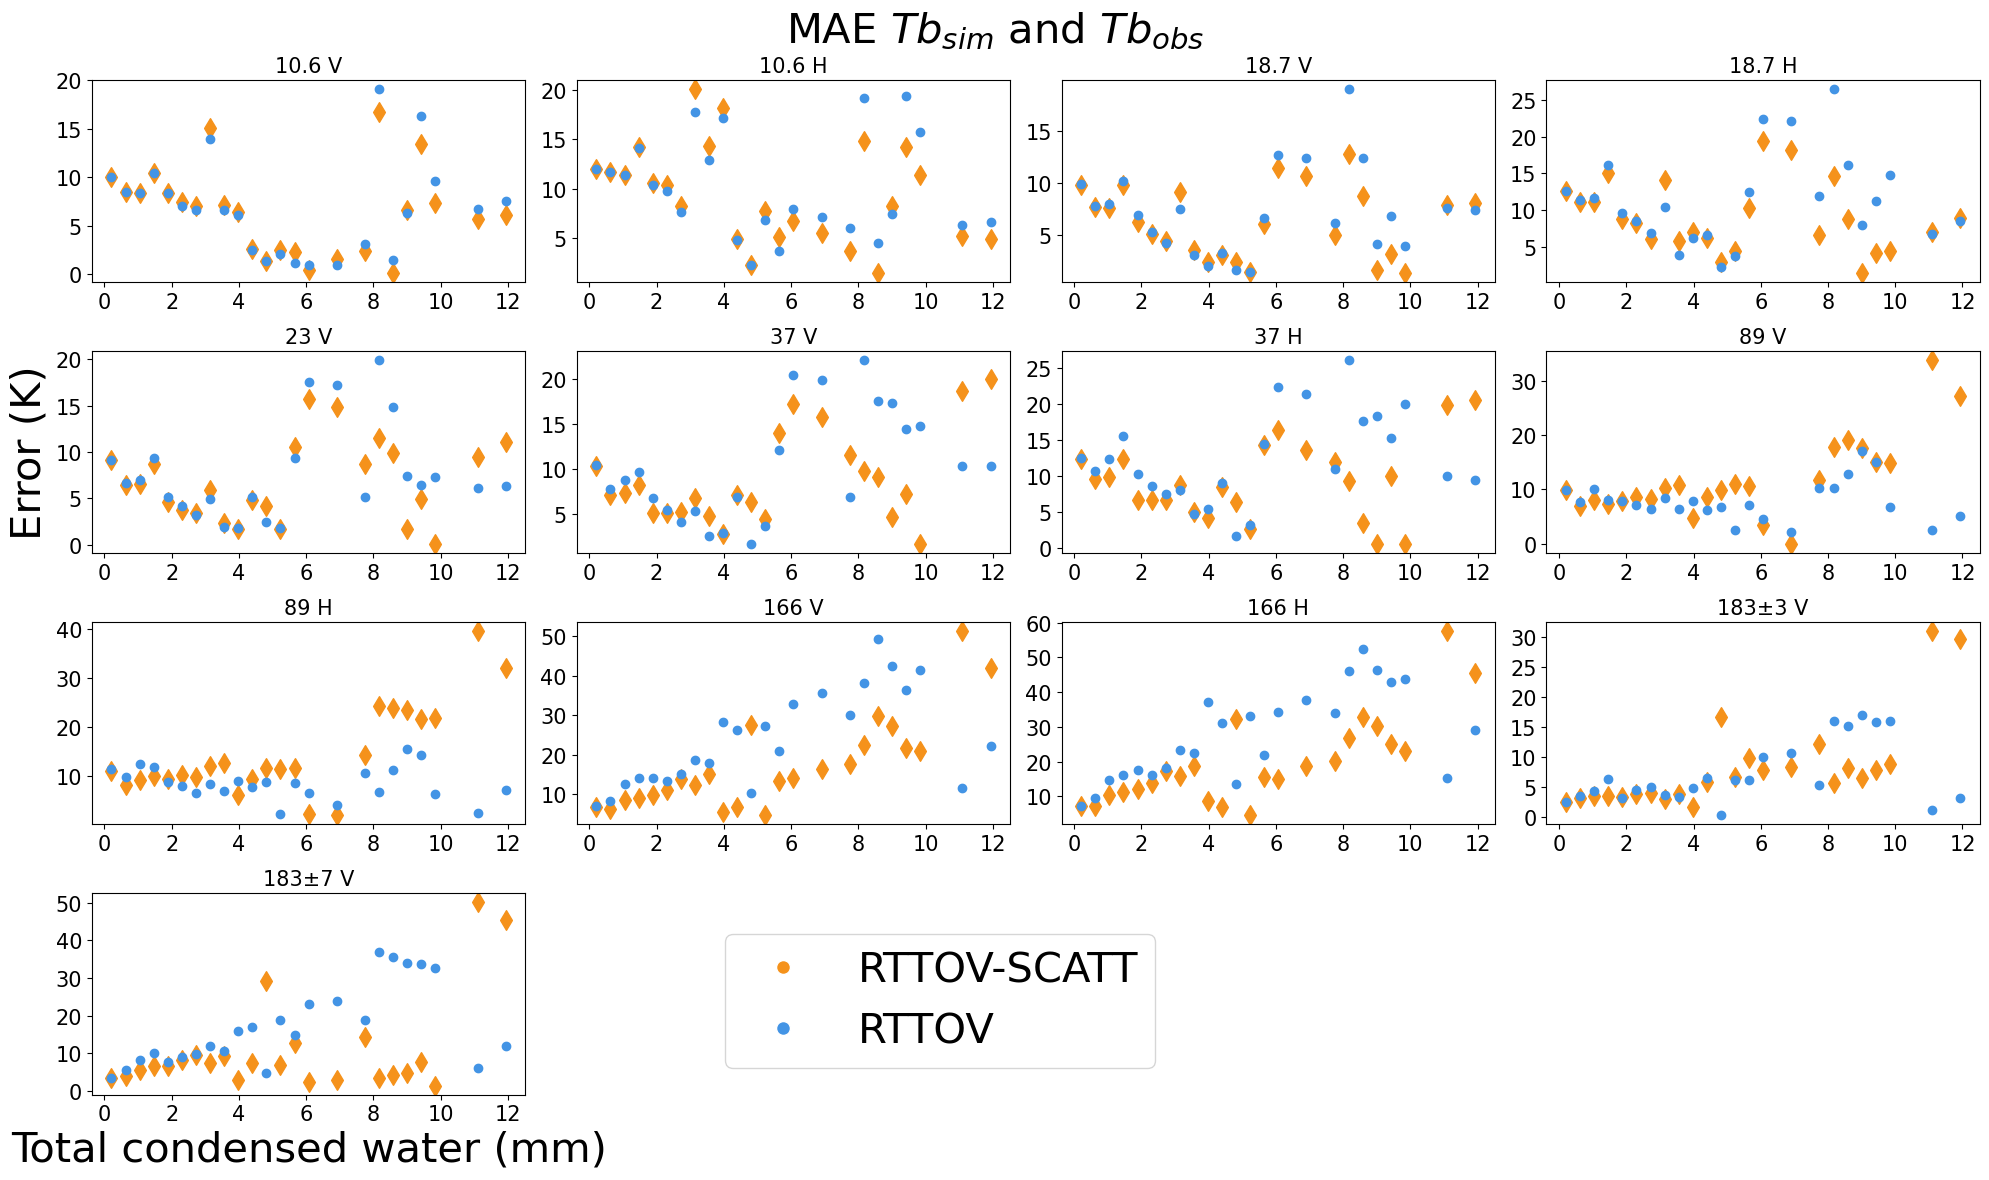

In [13]:
use_mask = land_mask | snow_mask | ice_mask

nbins = 30

bins = np.linspace(tcwv[use_mask].min(), tcwv[use_mask].max(), nbins+1)

error_clear = tc_sim_clear[valid_mask&use_mask] - tc_gmi[valid_mask&use_mask]
error_scatt = tc_sim_scatt[valid_mask&use_mask] - tc_gmi[valid_mask&use_mask]

bin_indices = np.digitize(tcwv[valid_mask&use_mask], bins) - 1

plt.figure(figsize=(20, 12))
for chan in range(13):
    plt.subplot(4, 4, chan+1)
    avg_errors_clear = []
    avg_errors_scatt = []

    for i in range(nbins):
        bin_mask = bin_indices == i
        
        avg_errors_clear.append(np.mean(np.abs(error_clear[bin_mask,chan])))
        avg_errors_scatt.append(np.mean(np.abs(error_scatt[bin_mask,chan])))

    avg_errors_clear = np.array(avg_errors_clear)
    avg_errors_scatt = np.array(avg_errors_scatt)

    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.scatter(bin_centers, avg_errors_scatt, c='#F5921B', marker='d', label='rttov-scatt', s=100)
    plt.scatter(bin_centers, avg_errors_clear, c='#4394E5', label='rttov')

    if chan == 12:
        plt.xlabel('Total condensed water (mm)', fontsize=30)
    if chan == 4:
        plt.ylabel('Error (K)', fontsize=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(channels[chan], fontsize=15)

plt.suptitle('MAE $Tb_{sim}$ and $Tb_{obs}$', fontsize=30)
plt.tight_layout()

legend_handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#F5921B', markersize=10, label='RTTOV-SCATT'),
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4394E5', markersize=10, label='RTTOV'),
]
plt.legend(handles=legend_handles, bbox_to_anchor=(2.5, 0.9), fontsize=30)

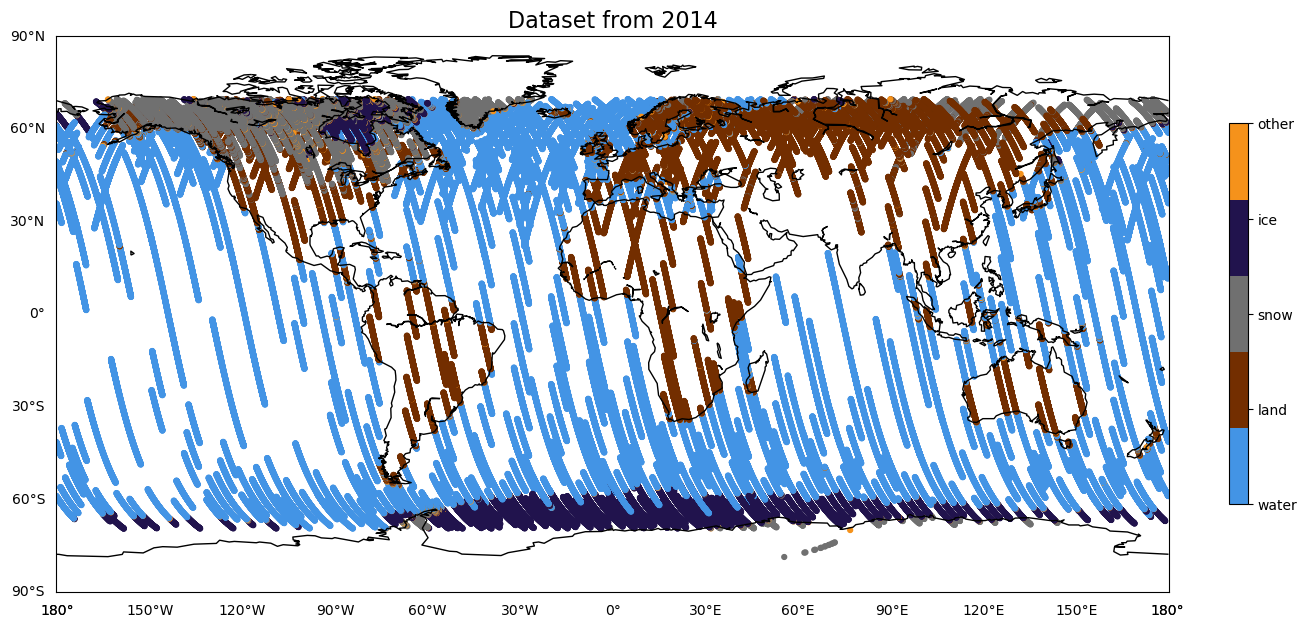

In [14]:
from mpl_toolkits.basemap import Basemap

plt.rcParams["figure.figsize"] = 13, 13

m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')

m.drawcoastlines()

parallels = range(-90, 91, 30)
meridians = range(0, 361, 30)
m.drawparallels(parallels, labels=[True, False, False, False], dashes=[], linewidth=0.0)
m.drawmeridians(meridians, labels=[False, False, False, True], dashes=[], linewidth=0.0)


colors = ['#4394E5', '#732E00', '#707070', '#21134D', '#F5921B']
cmap = matplotlib.colors.ListedColormap(colors)

plt.scatter(lon, lat, s=12, c=autosnow.clip(0, 4), cmap=cmap)

plt.title('Dataset from 2014', fontsize=16)
plt.tight_layout()
cbar = plt.colorbar(shrink=0.3, fraction=0.03)
cbar.set_ticks([0, 1, 2, 3, 4])
cbar.set_ticklabels(['water', 'land', 'snow', 'ice', 'other'])